In [1]:
# !apt install swig
# !pip install stable-baselines3[extra]

In [2]:
from google.colab import drive
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
drive.mount('/content/drive/',force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase')
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase/')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/BackUp_RL_CodeBase'

In [3]:
# specify comparison period, Max range 2003-12-31 : 2021-12-31
start ='2015-12-31' 
end = '2020-12-31'
result_dir = 'resultsRL/Tuned20152020/'

# Load Benchmark results

In [4]:
from pandas.compat.numpy.function import process_skipna
# 0 read benchmark performance input
raw_eq = pd.read_csv('benchmark_results/EQ.csv',index_col='date')
raw_mc = pd.read_csv('benchmark_results/MC.csv',index_col='date')
raw_gmv = pd.read_csv('benchmark_results/GMV.csv',index_col='date')
raw_msr = pd.read_csv('benchmark_results/MSR.csv',index_col='date')

In [5]:
# subset datas and align date
def subsetDate(df,start,end):
  df['date'] = df.index
  df = df[(df["date"] >= start) & (df["date"] < end)]
  df = df.drop(columns='date')
  return df

# compute performance
def port_Value(returns, start):
    """
    Takes a timeseries of asset returns
    Computes and returns a Dataframe that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    returns = returns.iloc[:,0]
    wealth_index = start*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns,
        "Port_return" : returns
    }, index=returns.index)

# subset data
pr_eq = pd.DataFrame(subsetDate(raw_eq,start,end).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,start,end).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,start,end).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,start,end).Port_Return)


# Load PPO model Results

In [6]:
schedule=pd.read_excel("trainingSchedule.xlsx",sheet_name = 'Value',index_col='Id')

In [7]:
# aggregate In-sample PPO results
for r in range(len(schedule.InSample)):
  # print(r)
  if r == 0:
    filename = f'{schedule.InSample[r]}.csv'
    # print(schedule.InSample[r])
    df_Insample = pd.read_csv(f'{result_dir}{filename}')
    print(f'{result_dir}{filename}')
  else:
    filename = f'{schedule.InSample[r]}.csv'
    # print(schedule.InSample[r])
    temp = pd.read_csv(f'{result_dir}{filename}')
    df_Insample = df_Insample.append(temp[1:])
    print(f'{result_dir}{filename}')
# adjust index
df_Insample.index= df_Insample.date

# aggregate Out-of-Sample PPO results
for r in range(len(schedule.OutofSample)):
  # print(r)
  if r == 0:
    filename = f'{schedule.OutofSample[r]}.csv'
    # print(schedule.OutofSample[r])
    df_OutofSample = pd.read_csv(f'{result_dir}{filename}')
  else:
    filename = f'{schedule.OutofSample[r]}.csv'
    # print(schedule.OutofSample[r])
    temp = pd.read_csv(f'{result_dir}{filename}')
    df_OutofSample = df_OutofSample.append(temp[1:])
# adjust index
df_OutofSample.index= df_OutofSample.date


resultsRL/Tuned20152020/PPO_0_InSample1415.csv
resultsRL/Tuned20152020/PPO_1_InSample1516.csv
resultsRL/Tuned20152020/PPO_2_InSample1617.csv
resultsRL/Tuned20152020/PPO_3_InSample1718.csv
resultsRL/Tuned20152020/PPO_4_InSample1819.csv
resultsRL/Tuned20152020/PPO_5_InSample1920.csv


# Long-Term Performance 2015-2020

In [8]:
# alignment date
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]

df_Insample = df_Insample.loc[intersect]
df_OutofSample = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)

ppo_IS = port_Value(pd.DataFrame(df_Insample.daily_return),initial_value)  
ppo_OS = port_Value(pd.DataFrame(df_OutofSample.daily_return),initial_value)  
  

Text(0.5, 0, 'Date')

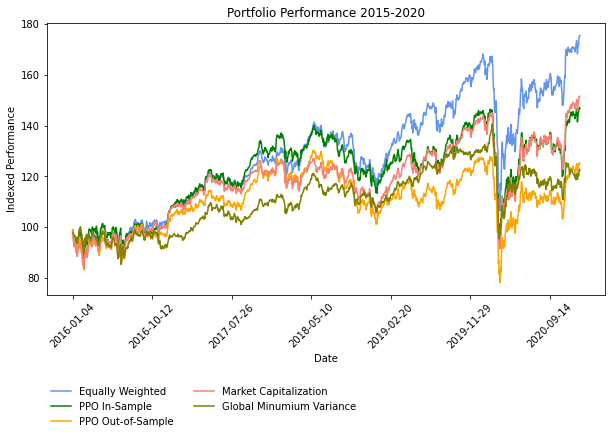

In [9]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2015-2020',figsize =(10,5))
ppo_IS.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

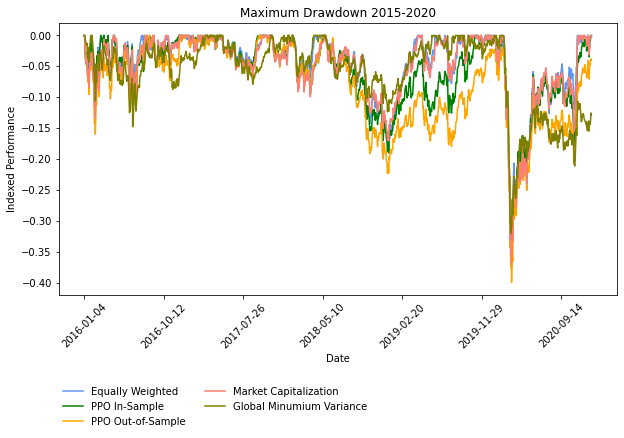

In [10]:
ax1 = eq.Drawdown.plot(color = 'cornflowerblue',label='Equally Weighted',title='Maximum Drawdown 2015-2020',figsize =(10,5))
ppo_IS.Drawdown.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS.Drawdown.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Drawdown.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Drawdown.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Drawdown.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45).legend(bbox_to_anchor=(1.0, 1.0))
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

In [11]:
df_portInd = pd.DataFrame({'PPO_IS':ppo_IS.Wealth/initial_value,
              'PPO_OS':ppo_OS.Wealth/initial_value,
              'MC':mc.Wealth/initial_value,
              'EQ':eq.Wealth/initial_value,
              'GMV':gmv.Wealth/initial_value,
              # 'MSR':msr.Wealth,
              'Year': [date[:4] for date in ppo_IS.index.tolist()] })
# df_portInd

In [12]:
df_port = pd.DataFrame({'PPO_IS':df_Insample.daily_return,
              'PPO_OS':df_OutofSample.daily_return,
              'MC':pr_mc.Port_Return,
              'EQ':pr_eq.Port_Return,
              'GMV':pr_gmv.Port_Return,
              # 'MSR':pr_msr.Port_Return,
              'Year': [date[:4] for date in df_Insample.index.tolist()] })
# df_port

## Annulized Volatiltiy

In [13]:
# annulized volatiltiy
pd.options.display.float_format = '{:.5}'.format
df_dailyVol = df_port.groupby(by='Year').std() 
df_period = df_port.groupby(by='Year').count()
annulized_vol = df_dailyVol * np.sqrt(df_period) 
annulized_vol=  np.round(annulized_vol*100,2)
annulized_vol = annulized_vol.transpose()
# Add Average Model
annulized_vol['Model'] = np.round(annulized_vol.mean(axis=1),2)
# Add Average through the year
avg_vol_year = np.round(pd.DataFrame(annulized_vol.mean(axis=0),columns=['Average']).T,2)
annulized_vol = annulized_vol.append(avg_vol_year)
annulized_vol
# annulized_vol.to_latex()

Year,2016,2017,2018,2019,2020,Model
PPO_IS,21.61,10.31,14.18,14.33,32.05,18.5
PPO_OS,22.9,10.27,15.15,14.13,32.35,18.96
MC,20.79,10.04,14.04,13.44,32.36,18.13
EQ,19.11,9.49,15.29,14.21,31.09,17.84
GMV,19.23,8.74,11.52,9.97,25.45,14.98
Average,20.73,9.77,14.04,13.22,30.66,17.68


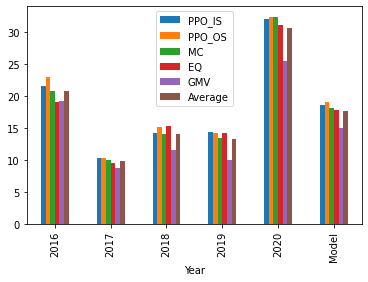

In [14]:
annulized_vol.T.plot.bar()

## Annulized Port Return

In [15]:
# arithmetic annulized return
pd.options.display.float_format = '{:.5}'.format
df_dailyAvgR = df_port.groupby(by='Year').mean() 
annulized_return = (1+df_dailyAvgR) ** df_period -1
annulized_return = np.round(annulized_return *100,2)
annulized_return = annulized_return.transpose()
# Add Average Model
annulized_return['Model'] = np.round(annulized_return.mean(axis=1),2)
# Add Average through the year
avg_vol_year = np.round(pd.DataFrame(annulized_return.mean(axis=0),columns=['Average']).T,2)
annulized_return = annulized_return.append(avg_vol_year)
annulized_return
# annulized_return.to_latex()

Year,2016,2017,2018,2019,2020,Model
PPO_IS,10.9,20.92,-10.37,25.76,7.44,10.93
PPO_OS,7.5,16.56,-14.08,23.01,4.99,7.6
MC,10.3,12.44,-10.3,32.58,13.25,11.65
EQ,9.77,17.39,-4.36,37.41,13.78,14.8
GMV,-0.98,13.79,-1.59,20.78,-2.24,5.95
Average,7.5,16.22,-8.14,27.91,7.44,10.19


In [16]:
# geometric average return
targetcol = df_port.columns[:-1]
temp = df_port[targetcol].apply(lambda x:x+1)
temp['Year'] = df_port['Year']
gar=temp.groupby(by='Year').prod()-1
gar=np.round(gar.T*100,2)

# Add Average Model
gar['Model'] = np.round(gar.mean(axis=1),2)
# Add Average through the year
avg_ret_year = np.round(pd.DataFrame(gar.mean(axis=0),columns=['Average']).T,2)
gar = gar.append(avg_ret_year)
# gar.to_latex()
gar

Year,2016,2017,2018,2019,2020,Model
PPO_IS,8.35,20.28,-11.26,24.48,2.01,8.77
PPO_OS,4.72,15.95,-15.06,21.8,-0.41,5.4
MC,7.94,11.88,-11.17,31.39,7.42,9.49
EQ,7.78,16.86,-5.47,36.03,8.39,12.72
GMV,-2.81,13.36,-2.24,20.19,-5.4,4.62
Average,5.2,15.67,-9.04,26.78,2.4,8.2


In [17]:
# pd.concat([annulized_vol,gar], axis=1) # too big

## Sharpe Ratio

Sharpe Ratio is a risk adjusted return which indicates the risk efficiency, a higher sharpe ratio indicates higher return per unit risk taken. The average sharpe ratio of all models varies strongly through the year, indicates the performance of the portfolios relies strongly on the market movement. The range of the average sharpe ratio falls between -0.5 and 2.3. In the year 2019, the average sharpe ratio of all the models is 2.3. In the year 2018, the lowest average sharpe ratio of -0.5.

In order to compare the models, we have compted the average sharpe ratio based on five year test period. The equally weighted portfolio has the higehst sharpe ratio of 0.83, followed by In sample PPO-based portfolio and Market-cap weighted portoflio. 


In [18]:
df_SR = np.round(gar/annulized_vol,2)
# df_SR.to_latex()
df_SR

Year,2016,2017,2018,2019,2020,Model
PPO_IS,0.39,1.97,-0.79,1.71,0.06,0.47
PPO_OS,0.21,1.55,-0.99,1.54,-0.01,0.28
MC,0.38,1.18,-0.8,2.34,0.23,0.52
EQ,0.41,1.78,-0.36,2.54,0.27,0.71
GMV,-0.15,1.53,-0.19,2.03,-0.21,0.31
Average,0.25,1.6,-0.64,2.03,0.08,0.46


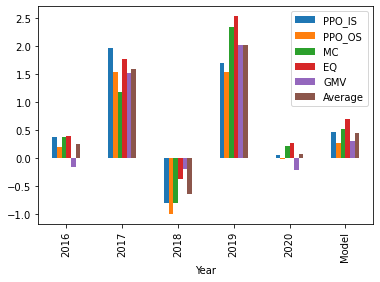

In [19]:
df_SR.T.plot.bar()

# Random Agent

In [20]:
df=pd.read_pickle("Input/E_cleanInput.pkl")
df=df.sort_values(['tic','date'],ignore_index=True) 

In [21]:
#small helpers
from helpers.envPort import StockPortfolioEnv
from helpers.helperFunction import data_split,splitByRatio  

#standard lib
import gym
from gym.utils import seeding
from gym import spaces

from stable_baselines3.common.vec_env import DummyVecEnv,VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, DDPG, PPO
from stable_baselines3.common.logger import configure
import torch as th

import matplotlib.pyplot as plt
%matplotlib inline

# Bearish market in 2018

## Random agent 2018

In [47]:
s18 = '2017-12-29'
e18 = '2018-12-31'
train = data_split(df, s18,e18) # index resetted

# environment setting
stock_dimension = len(train.tic.unique())
state_space =1 # single input for state representation
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# define environment
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
print( f'action space: {e_train_gym.action_space}, observation_space: {e_train_gym.observation_space}')
# get_attributes(e_train_gym)

#normalize the environment
mon_env = Monitor(e_train_gym,allow_early_resets=False)
env = DummyVecEnv([lambda:mon_env])
e_train_gym = VecNormalize(env)


Stock Dimension: 42, State Space: 1
action space: Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.], (42,), float32), observation_space: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]], [[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf]], (1, 43), float32)


Streaming output truncated to the last 5000 lines.
portfolio return:0.0017316055268986402
portfolio value:1.1041101252433516
new portfolio value: 1.1060220084385277
done:False
Model actions:  [5.817761   9.921592   9.135841   2.1622834  8.244969   6.3238244
 9.797129   4.9701304  7.419065   4.089382   1.2388461  2.824916
 3.901147   4.980213   3.9321089  4.5061884  6.028371   6.8211923
 9.798396   9.796485   2.5292273  4.372084   0.39782283 2.8104415
 9.129941   3.9092433  4.7563095  1.0304627  6.311993   4.477068
 8.562129   7.791174   1.7096694  6.918045   4.818178   9.62894
 7.0767875  9.851261   8.9814005  9.538061   7.090938   1.0367295 ]
Weights:  [1.98698393e-03 1.20355360e-01 5.48552722e-02 5.13618543e-05
 2.25070007e-02 3.29590682e-03 1.06270283e-01 8.51281395e-04
 9.85443871e-03 3.52832838e-04 2.03984382e-05 9.96364470e-05
 2.92293669e-04 8.59908061e-04 3.01485241e-04 5.35285682e-04
 2.45279400e-03 5.41974790e-03 1.06405050e-01 1.06201895e-01
 7.41314216e-05 4.68106766e-04 8.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


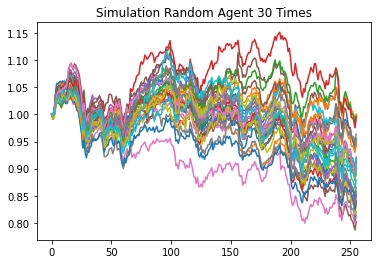

In [48]:
nSim =30
# wrapper on the environment, monitor episodic reward while taking random actions
e_train_rnd = StockPortfolioEnv(df = train, **env_kwargs)
e_train_rnd = Monitor(e_train_rnd) # do not log
ls_eps_reward = []
ls_trajectory = {}
# test for 3 times
for i in range(nSim):
  #episodic length
  e_train_rnd.reset()
  done = e_train_rnd.terminal
  e_train_rnd.action_space.np_random.seed(i)
  while not done:
    # e_train_rnd.seed(321)
    r_act = e_train_rnd.action_space.sample()
    obs, reward, done ,info  = e_train_rnd.step(r_act)
    print(f'done:{done}')
  eps_reward = e_train_rnd.get_episode_rewards()
  ls_trajectory[i] = e_train_rnd.save_asset_memory()
ls_eps_reward.append(eps_reward)
print(f'episodic reward:{ls_eps_reward}')
# 2) df daily return simulation
mcSim = ls_trajectory[0] 
mcSim=mcSim.rename(columns = {'daily_return':'sim_0'})
mcSim['sim_'+str(0)].iloc[0] = 0
for m in range(1,nSim):
  mcSim['sim_'+str(m)] = ls_trajectory[m].daily_return
  mcSim['sim_'+str(m)].iloc[0] = 0
# compute index performance
rndAgent = pd.DataFrame()
rndAgent['date'] = mcSim['date']
for m in range(0,nSim):
  rndAgent['simRun_'+str(m)] = (mcSim['sim_'+str(m)]+1).cumprod()
#3) plot simulation, legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
randMean = np.round(rndAgent.mean(axis=1).iloc[-1],4)
randStd = np.round(rndAgent.std(axis=1).iloc[-1],4)
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

mean: 0.893, std: 0.0557


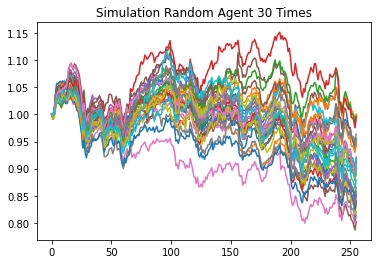

In [49]:
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

In [50]:
# Min Max of the Random Agent
rndAgent = rndAgent.set_index(keys='date', drop=True) # reset index
rndMax = rndAgent.idxmax(axis=1)[-1] # return sim with max end return
rndMin = rndAgent.idxmin(axis=1)[-1] # return sim with max end return

## Benchmarks and models

In [51]:
s18 = '2017-12-29'
e18 = '2018-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s18,e18).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s18,e18).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s18,e18).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s18,e18).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2018 = df_Insample.loc[intersect]
df_OutofSample2018 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2018 = port_Value(pd.DataFrame(df_Insample2018.daily_return),initial_value)  
ppo_OS2018 = port_Value(pd.DataFrame(df_OutofSample2018.daily_return),initial_value)  
  

## Performance chart

Text(0.5, 0, 'Date')

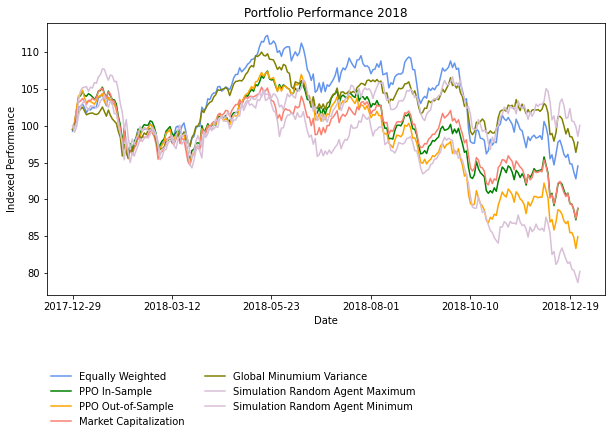

In [52]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2018',figsize =(10,5))
ppo_IS2018.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2018.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
#random agent
(rndAgent[rndMax]*100).plot(label='Simulation Random Agent Maximum',legend=True,ax=ax1,color ='thistle')
(rndAgent[rndMin]*100).plot(label='Simulation Random Agent Minimum',legend=True,ax=ax1,color='thistle')


ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

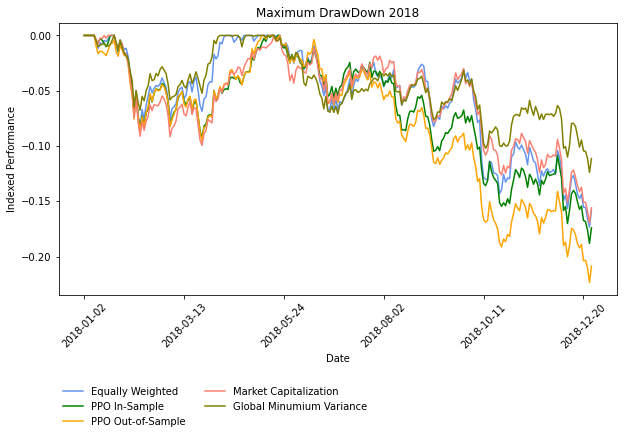

In [53]:
ax1 = eq.Drawdown.plot(color = 'cornflowerblue',label='Equally Weighted',title='Maximum DrawDown 2018',figsize =(10,5))
ppo_IS2018.Drawdown.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2018.Drawdown.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Drawdown.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Drawdown.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

# Bullish Market 2019

## random agent 2019

In [54]:
s19 = '2018-12-31'
e19 = '2019-12-31'
train = data_split(df, s19,e19) # index resetted

# environment setting
stock_dimension = len(train.tic.unique())
state_space =1 # single input for state representation
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# define environment
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
print( f'action space: {e_train_gym.action_space}, observation_space: {e_train_gym.observation_space}')
# get_attributes(e_train_gym)

#normalize the environment
mon_env = Monitor(e_train_gym,allow_early_resets=False)
env = DummyVecEnv([lambda:mon_env])
e_train_gym = VecNormalize(env)


Stock Dimension: 42, State Space: 1
action space: Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.], (42,), float32), observation_space: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]], [[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf]], (1, 43), float32)


Streaming output truncated to the last 5000 lines.

[1 rows x 42 columns]
portfolio return:-0.01946127393329116
portfolio value:1.1254598338128676
new portfolio value: 1.1035569516861192
done:False
Model actions:  [0.03913986 2.4973533  9.210753   4.8938046  2.1985137  9.701271
 3.335596   6.685564   1.1136498  7.2986436  6.7617297  4.6537347
 5.9246874  9.758876   3.2984712  9.140328   1.1900419  9.336289
 9.545996   9.154749   7.290176   6.8077016  6.1606035  4.1569347
 0.2919306  7.483809   0.16224886 5.770909   7.972278   8.552858
 2.4924805  2.3553052  5.4271393  4.4687333  5.5412498  4.364902
 8.180889   5.0986614  7.8505816  5.841862   9.857857   9.107618  ]
Weights:  [7.42029806e-06 8.66981572e-05 7.13842735e-02 9.52303642e-04
 6.43021558e-05 1.16582036e-01 2.00472175e-04 5.71382185e-03
 2.17307697e-05 1.05483308e-02 6.16602087e-03 7.49056169e-04
 2.66982079e-03 1.23494901e-01 1.93166139e-04 6.65299743e-02
 2.34558793e-05 8.09323341e-02 9.98151302e-02 6.74963146e-02
 1.04593877

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


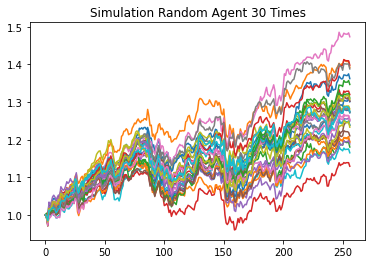

In [55]:
nSim =30
# wrapper on the environment, monitor episodic reward while taking random actions
e_train_rnd = StockPortfolioEnv(df = train, **env_kwargs)
e_train_rnd = Monitor(e_train_rnd) # do not log
ls_eps_reward = []
ls_trajectory = {}
# test for 3 times
for i in range(nSim):
  #episodic length
  e_train_rnd.reset()
  done = e_train_rnd.terminal
  e_train_rnd.action_space.np_random.seed(i)
  while not done:
    # e_train_rnd.seed(321)
    r_act = e_train_rnd.action_space.sample()
    obs, reward, done ,info  = e_train_rnd.step(r_act)
    print(f'done:{done}')
  eps_reward = e_train_rnd.get_episode_rewards()
  ls_trajectory[i] = e_train_rnd.save_asset_memory()
ls_eps_reward.append(eps_reward)
print(f'episodic reward:{ls_eps_reward}')
# 2) df daily return simulation
mcSim = ls_trajectory[0] 
mcSim=mcSim.rename(columns = {'daily_return':'sim_0'})
mcSim['sim_'+str(0)].iloc[0] = 0
for m in range(1,nSim):
  mcSim['sim_'+str(m)] = ls_trajectory[m].daily_return
  mcSim['sim_'+str(m)].iloc[0] = 0
# compute index performance
rndAgent = pd.DataFrame()
rndAgent['date'] = mcSim['date']
for m in range(0,nSim):
  rndAgent['simRun_'+str(m)] = (mcSim['sim_'+str(m)]+1).cumprod()
#3) plot simulation, legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
randMean = np.round(rndAgent.mean(axis=1).iloc[-1],4)
randStd = np.round(rndAgent.std(axis=1).iloc[-1],4)
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

In [56]:
# Min Max of the Random Agent
rndAgent = rndAgent.set_index(keys='date', drop=True) # reset index
rndMax = rndAgent.idxmax(axis=1)[-1] # return sim with max end return
rndMin = rndAgent.idxmin(axis=1)[-1] # return sim with max end return

## Benchmarks and models

In [57]:
s19 = '2018-12-31'
e19 =	'2019-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s19,e19).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s19,e19).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s19,e19).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s19,e19).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2019 = df_Insample.loc[intersect]
df_OutofSample2019 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2019 = port_Value(pd.DataFrame(df_Insample2019.daily_return),initial_value)  
ppo_OS2019 = port_Value(pd.DataFrame(df_OutofSample2019.daily_return),initial_value)  
  

## Performance chart

Text(0.5, 0, 'Date')

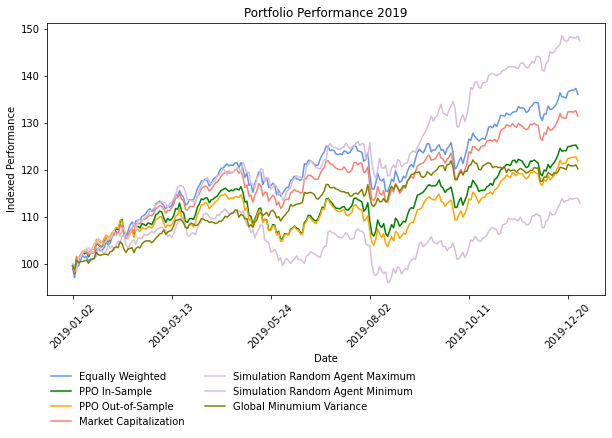

In [59]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2019',figsize =(10,5))
ppo_IS2019.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2019.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')

# random agent
(rndAgent[rndMax]*100).plot(label='Simulation Random Agent Maximum',legend=True,ax=ax1,color ='thistle')
(rndAgent[rndMin]*100).plot(label='Simulation Random Agent Minimum',legend=True,ax=ax1,color='thistle')


gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

## Allocation

In [34]:
# weight is not cleaned yet
# msr_wgt = pd.read_csv('benchmark_results/wgt_msr.csv',index_col ='date')
gmv_weight = pd.read_csv('benchmark_results/wgt_gmv.csv',index_col ='date')
mc_wgt = pd.read_csv('benchmark_results/wgt_mc.csv',index_col ='date')

# subset weights
# msr_actions = subsetDate(msr_wgt)
gmv_actions = subsetDate(gmv_weight,s19,e19)
mc_actions = subsetDate(mc_wgt,s19,e19)

In [35]:
# list_date = msr_actions.index.tolist()
# xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
# msr_actions.plot.bar(title ='Allocation MSR Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
# plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
# plt.show()

In [36]:
# msr_actions.iloc[0].sort_values(ascending=False)

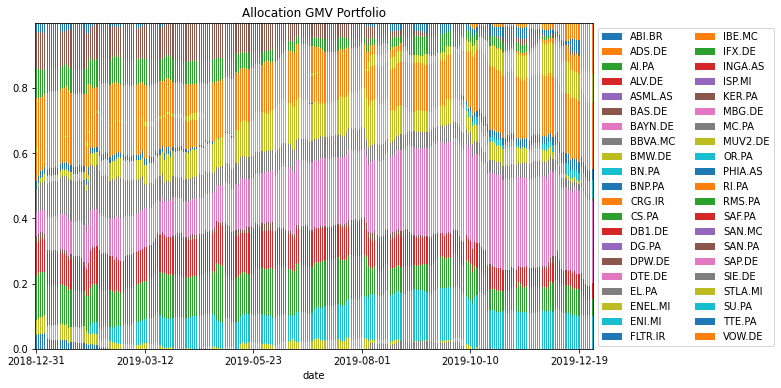

In [37]:
list_date = gmv_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
gmv_actions.plot.bar(title ='Allocation GMV Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [38]:
gmv_actions.mean(axis=0).sort_values(ascending=False).head()

DTE.DE    0.19174
IBE.MC    0.11503
CS.PA     0.10949
BN.PA    0.096099
DB1.DE   0.092101
dtype: float64

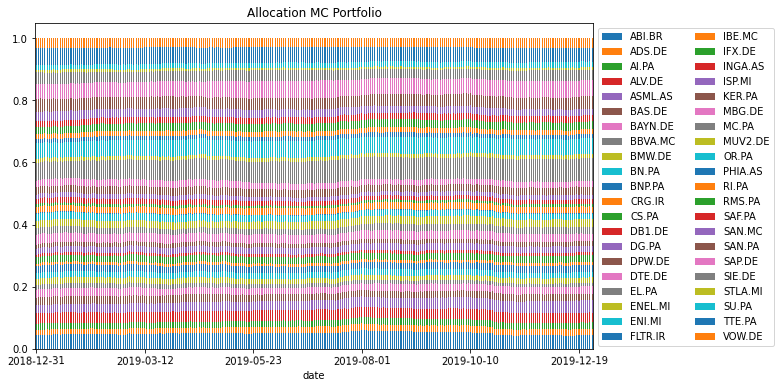

In [39]:
list_date = mc_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
mc_actions.plot.bar(title ='Allocation MC Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [40]:
# gmv_actions.mean(axis=0).sort_values(ascending=False).head()
mc_actions.mean(axis=0).sort_values(ascending=False).head()

MC.PA    0.067644
OR.PA    0.051844
SAP.DE   0.051341
ABI.BR   0.049704
TTE.PA   0.049228
dtype: float64

In [41]:
ppo19IS = pd.read_csv('resultsRL/20152020/PPO_4_InSample1819A.csv',index_col='date')
ppo19OS = pd.read_csv('resultsRL/20152020/PPO_3_OutofSample1819A.csv',index_col='date')

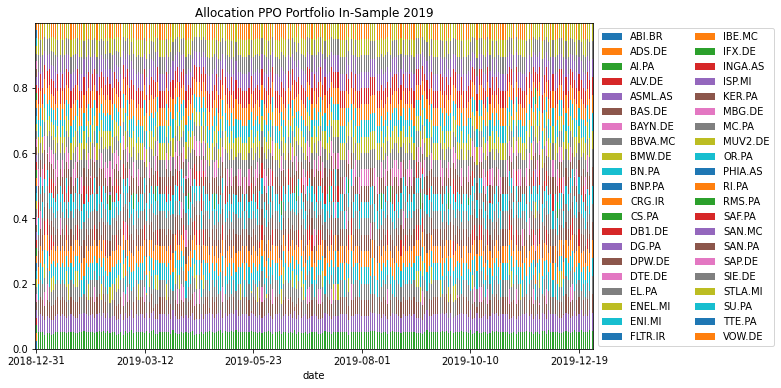

In [42]:
list_date = ppo19IS.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
ppo19IS.plot.bar(title ='Allocation PPO Portfolio In-Sample 2019',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [43]:
# gmv_actions.mean(axis=0).sort_values(ascending=False).head()
# mc_actions.mean(axis=0).sort_values(ascending=False).head()
ppo19IS.mean(axis=0).sort_values(ascending=False).head()

STLA.MI   0.050856
SAN.MC    0.050856
SAF.PA    0.050856
DPW.DE    0.050856
SIE.DE    0.050856
dtype: float64

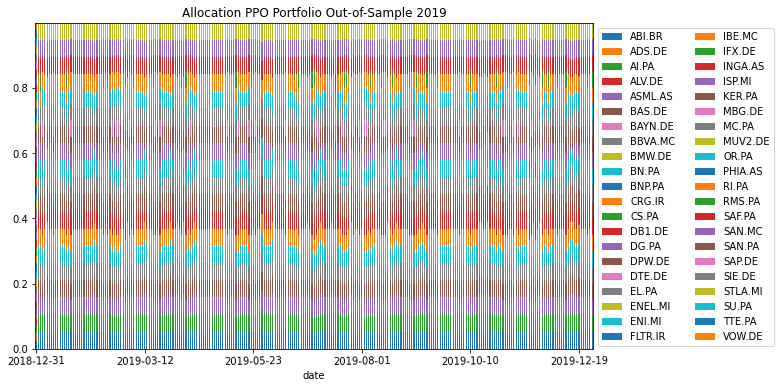

In [44]:
list_date = ppo19OS.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
ppo19OS.plot.bar(title ='Allocation PPO Portfolio Out-of-Sample 2019',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

#Market Crash 2020

In [75]:
s20 = '2019-12-29'
e20 = '2020-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s20,e20).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s20,e20).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s20,e20).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s20,e20).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2020 = df_Insample.loc[intersect]
df_OutofSample2020 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2020 = port_Value(pd.DataFrame(df_Insample2020.daily_return),initial_value)  
ppo_OS2020 = port_Value(pd.DataFrame(df_OutofSample2020.daily_return),initial_value)  
  

Text(0.5, 0, 'Date')

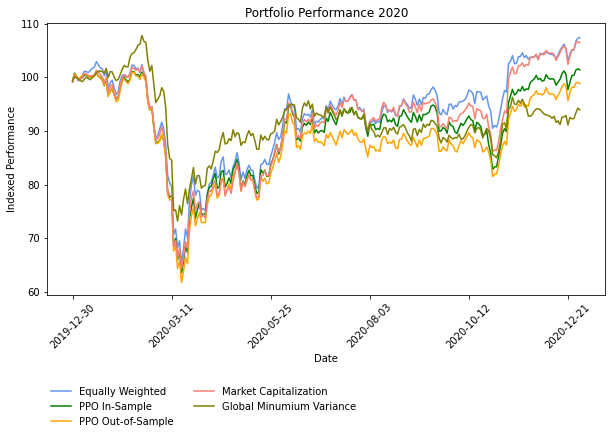

In [78]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2020',figsize =(10,5))
ppo_IS2020.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2020.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')